In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Input 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

folder_path = '.'
image_file_name = '/images.npy'
label_file_name = '/labels.npy'

images = np.load(folder_path+image_file_name)
images = np.expand_dims(images, axis=-1)
labels = np.load(folder_path+label_file_name)

# Think I stole this from somewhere but not sure where
def shuffle_in_unison(a, b):
    if len(a) != len(b):
        raise ValueError('Two arrays are incompatible for shuffling in unison')
    p = np.random.permutation(len(a))
    return a[p], b[p]

images, labels = shuffle_in_unison(images,labels)

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2025-11-08 04:25:20.829823: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-08 04:25:20.841164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762572320.849834 1793662 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762572320.852373 1793662 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762572320.859423 1793662 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
def train_test_valid_split(a,b,train=0.8,test=0.1,valid=0.1,shuffle=True,check_data = False):
    if len(a) != len(b):
        raise ValueError('Two arrays are incompatible for splitting in unison')
    total_percentage = train + test + valid
    if total_percentage != 1:
        raise ValueError(f'''Data will not be split correctly \n 
        Total percentage of data used :{total_percentage*100}% \n 
        Training = {train*100}%, testing = {test*100}%, validation = {valid*100}%''')
    if shuffle == True:
        a, b = shuffle_in_unison(a,b)
    
    train_idx = int(len(a)*train)
    test_idx = train_idx+int(len(a)*test)
    valid_idx = len(a)
    train_x = a[:train_idx]
    test_x = a[train_idx:test_idx]
    valid_x = a[test_idx:]
    train_y = b[:train_idx]
    test_y = b[train_idx:test_idx]
    valid_y = b[test_idx:]

    
    if check_data:
        check_len_match = len(train_x) + len(test_x) + len(valid_x)
        print(f'Size of train, test and valid: {len(train_x)},{len(test_x)},{len(valid_x)}')
        if check_len_match == len(a):
            print('yippee')
        else:
            print('no:(')
    
    return train_x, train_y, test_x, test_y, valid_x, valid_y

In [4]:
def check_random_sample(a,b,c=None):
    rand_int=np.random.randint(0,len(a))
    plt.imshow(a[rand_int],cmap='gray')
    plt.show()
    if isinstance(b, list):
        cos_h_true, sin_h_true = b[0][rand_int]
        cos_m_true, sin_m_true = b[1][rand_int]
        hour_true = int(round((np.arctan2(sin_h_true,cos_h_true)%(2*np.pi)) * 12/(2*np.pi)))
        minute_true = int(round((np.arctan2(sin_m_true,cos_m_true)%(2*np.pi)) * 60/(2*np.pi)))
        # hour_true = int(b[0][rand_int].item()*12/(2*np.pi))
        # minute_true = int(b[1][rand_int].item()*60/(2*np.pi))
        print(f"The time is {hour_true:02d}:{minute_true:02d}")
        if c:   
            cos_h_pred, sin_h_pred = c[0][rand_int]
            cos_m_pred, sin_m_pred = c[1][rand_int]
            hour_pred = int(round((np.arctan2(sin_h_pred,cos_h_pred)%(2*np.pi)) * 12/(2*np.pi)))
            minute_pred = int(round((np.arctan2(sin_m_pred,cos_m_pred)%(2*np.pi)) * 60/(2*np.pi)))
            # hour_pred = int(c[0][rand_int].item()*12/(2*np.pi))
            # minute_pred = int(c[1][rand_int].item()*60/(2*np.pi))
            print(f'The predicted time is {hour_pred:02d}:{minute_pred:02d}')
        
    else:
        print(b[rand_int])

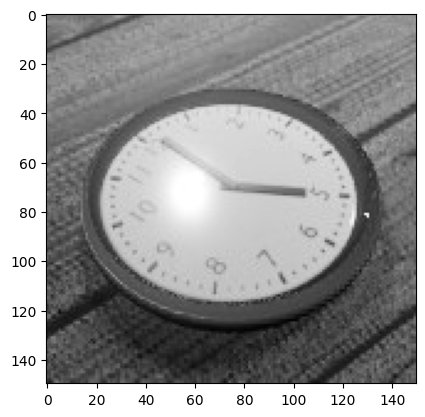

The time is 05:01


In [5]:
from tensorflow.keras.utils import to_categorical
scaler = MinMaxScaler(feature_range=(0, 1))
train_x, train_y, test_x, test_y, valid_x, valid_y = train_test_valid_split(images, labels)

train_x = train_x.astype('float32') / 255.0
valid_x = valid_x.astype('float32') / 255.0
test_x = test_x.astype('float32') / 255.0

hour_train = (train_y[:,0]*2*np.pi)/12
minute_train = (train_y[:,1]*2*np.pi)/60

hour_valid = (valid_y[:,0]*2*np.pi)/12
minute_valid = (valid_y[:,1]*2*np.pi)/60

hour_test = (test_y[:,0]*2*np.pi)/12
minute_test = (test_y[:,1]*2*np.pi)/60

hour_train, minute_train = np.column_stack([np.cos(hour_train),np.sin(hour_train)]),np.column_stack([np.cos(minute_train),np.sin(minute_train)])
hour_valid, minute_valid = np.column_stack([np.cos(hour_valid),np.sin(hour_valid)]),np.column_stack([np.cos(minute_valid),np.sin(minute_valid)])
hour_test, minute_test = np.column_stack([np.cos(hour_test),np.sin(hour_test)]),np.column_stack([np.cos(minute_test),np.sin(minute_test)])

train_y=[hour_train,minute_train]
valid_y=[hour_valid,minute_valid]
test_y=[hour_test,minute_test]
check_random_sample(train_x,train_y)

In [6]:
train_input_dim = (150, 150, 1)

In [7]:
import os
import datetime
if os.path.isdir("logs"):
    print('directory exists')
else:
    os.mkdir('./logs')
    os.mkdir('./logs/fit')
if os.path.isdir('models'):
    print('model directory exists')
else:
    os.mkdir('./models')
if os.path.isdir('plots'):
    print('plot directory exists')
else:
    os.mkdir('./plots')
if os.path.isdir('history'):
    print('history directory exists')
else:
    os.mkdir('./history')


directory exists
model directory exists
plot directory exists
history directory exists


In [8]:
from os import listdir
from os.path import isfile, join
def get_iter(path,file_prefix=None):

    files = [f for f in listdir(path) if isfile(join(path, f))]
    iterations = []
    if file_prefix is not None:
        files = [file for file in files if file_prefix in file]

    if not files:
        return 1

    for file in files:
        file = file.split(".", 1)[0]
        try:
            iteration = int(file.split("_")[-1])
            iterations.append(iteration)
        except ValueError:
            continue
    iterations.sort(reverse=True)
    return iterations[0] + 1

In [9]:
from tensorflow.keras.layers import Lambda


def unit_vector(x):
    return tf.math.l2_normalize(x, axis=1)

#took inspiration from alex net for this 
def cnn(input_image_shape=(75,75,1)):
    
    inputs = Input(shape=input_image_shape)
    x = Conv2D(32, kernel_size=(3,3), strides= 1,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_image_shape,
                    kernel_initializer= 'he_normal')(inputs)
    x = MaxPooling2D(pool_size=(3,3), strides= (2,2),
                            padding= 'valid', data_format= None)(x)

    x = Conv2D(64, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal')(x)
    x = MaxPooling2D(pool_size=(3,3), strides= (2,2),
                            padding= 'valid', data_format= None)(x)

    x = Conv2D(128, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(128, activation= 'relu')(x)
    hour_vec = Dense(2, activation= 'linear')(x)
    hour_output = Lambda(unit_vector, name='hour_output')(hour_vec)
    minute_vec = Dense(2,activation= 'linear')(x)
    minute_output = Lambda(unit_vector, name='minute_output')(minute_vec)
    
    model = Model(inputs=inputs,outputs=[hour_output,minute_output])

    model.compile(optimizer= tf.keras.optimizers.Adam(0.001),
            loss={"hour_output": "mse",
                "minute_output": "mse"},
            loss_weights={"hour_output": 1,
                        "minute_output": 1},
            metrics={"hour_output": "mse",
                    "minute_output": "mse"}
                    )
    return model

In [10]:
path = './models'
iteration = get_iter(path,file_prefix='part_iv_')

In [ ]:
# Can get stuck on local minima so need to run like a few times to get a good RNG start

model = cnn(train_input_dim)

path = './models'
iteration = get_iter(path,file_prefix='model')


epochs = 500
batch_size = 128
model_dir = f"./models/part_iv_model_full_{iteration}.h5"

callback_list = [EarlyStopping(monitor='val_loss',
                               patience=30,
                               mode='auto',
                               start_from_epoch=0,
                               restore_best_weights=True)]
                #  ReduceLROnPlateau(monitor='val_loss',
                #                    patience=10,
                #                    mode='auto')]


history = model.fit(    train_x,
                        train_y,
                        epochs=epochs,
                        validation_data=(valid_x, valid_y),
                        callbacks=callback_list,
                        verbose=1,
                        batch_size = batch_size
)

model.save(model_dir)

/vol/home/s4557093/.conda/envs/tf-gpu/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500


2025-11-07 13:18:45.306346: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - hour_output_loss: 1.0046 - hour_output_mse: 1.0046 - loss: 2.0133 - minute_output_loss: 1.0086 - minute_output_mse: 1.0086 - val_hour_output_loss: 0.9609 - val_hour_output_mse: 0.9912 - val_loss: 1.9940 - val_minute_output_loss: 1.0166 - val_minute_output_mse: 1.0028
Epoch 2/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - hour_output_loss: 1.0073 - hour_output_mse: 1.0073 - loss: 2.0036 - minute_output_loss: 0.9962 - minute_output_mse: 0.9962 - val_hour_output_loss: 0.9611 - val_hour_output_mse: 0.9916 - val_loss: 2.0100 - val_minute_output_loss: 1.0327 - val_minute_output_mse: 1.0184
Epoch 3/500
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - hour_output_loss: 1.0055 - hour_output_mse: 1.0055 - loss: 2.0019 - minute_output_loss: 0.9963 - minute_output_mse: 0.9964 - val_hour_output_loss: 0.9617 - val_hour_output_mse: 0.9927 - val_loss: 2.0139 - val_minute_output_loss: 1.0314 - val_minute_output_mse: 1.0212
Epoch 4/500
113/113 ━━━━━━━━━━━━━━━━━━

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanAbsoluteError, CategoricalAccuracy, MeanSquaredError
custom_objects = {
    'mae': MeanAbsoluteError,
    "MeanAbsoluteError": MeanAbsoluteError,
    "CategoricalAccuracy": CategoricalAccuracy,
    'unit_vector': unit_vector,
    'mse': MeanSquaredError
}

model = load_model('./models/part_iv_model_full_8.h5', custom_objects = custom_objects)


I0000 00:00:1762572610.311743 1905275 service.cc:152] XLA service 0x75d494003810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762572610.311763 1905275 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-11-08 04:30:10.317842: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762572610.337441 1905275 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-08 04:30:10.555983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads



46/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

I0000 00:00:1762572611.328800 1905275 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


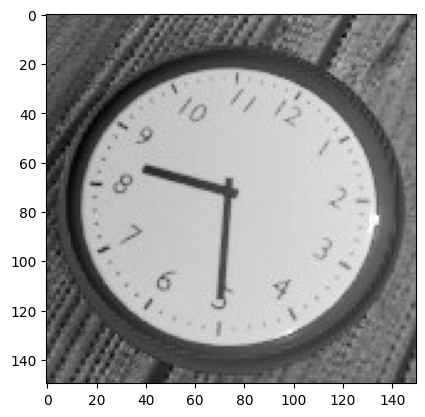

The time is 08:25
The predicted time is 08:25


In [15]:
predictions = model.predict(test_x)

check_random_sample(test_x,test_y,predictions)


In [ ]:
hist_df = pd.DataFrame(history.history)
hist_path=f'./history/history{iteration}.csv'
with open(hist_path, mode='w') as f:
    hist_df.to_csv(f)


Index(['hour_output_loss', 'hour_output_mse', 'loss', 'minute_output_loss',
       'minute_output_mse', 'val_hour_output_loss', 'val_hour_output_mse',
       'val_loss', 'val_minute_output_loss', 'val_minute_output_mse'],
      dtype='object')


In [136]:
def plot_history_loss(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label],'r-',label='Training') 
    plt.plot(history[second_label],'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/loss_history_model_{iteration}.jpg' 
    else: 
        savedir = savedir + 'loss_history_model_{iteration}.jpg' 
    plt.savefig(savedir) 
    plt.show() 
    
def plot_history_accuracy(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label]*100,'r-',label='Training') 
    plt.plot(history[second_label]*100,'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy (%)') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/accuracy_history_model_{iteration}.jpg' 
    else: savedir = savedir + 'accuracy_history_model_{iteration}.jpg' 
    plt.savefig(savedir) 
    plt.show() 
    
def plot_history_mae(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label],'r-',label='Training') 
    plt.plot(history[second_label],'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Mean absolute error') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/mae_history_model_{iteration}.jpg' 
    else: 
        savedir = savedir + 'mae_history_model_{iteration}.jpg' 
    plt.savefig(savedir)
    plt.show() 

def plot_history_mse(history,first_label=None,second_label=None,title=None,savedir=None): 
    if first_label is None or second_label is None: 
        raise TypeError(f'labels need to be provided: first label {first_label}, second label {second_label}') 
    plt.plot(history[first_label],'r-',label='Training') 
    plt.plot(history[second_label],'b-',label='Validation') 
    plt.xlabel('Epochs') 
    plt.ylabel('Mean square error') 
    plt.title(title) 
    plt.legend() 
    if savedir is None: 
        savedir = f'./plots/{title}{iteration}.jpg' 
    else: 
        savedir = savedir + '{title}{iteration}.jpg' 
    plt.savefig(savedir)
    plt.show() 

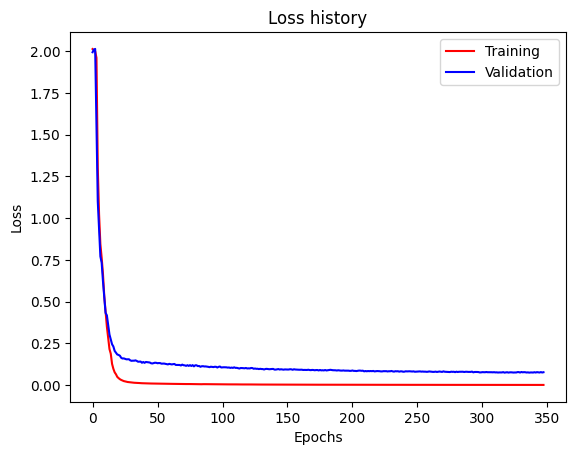

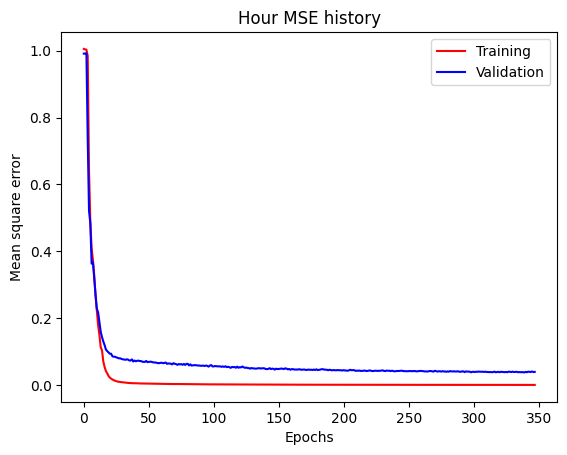

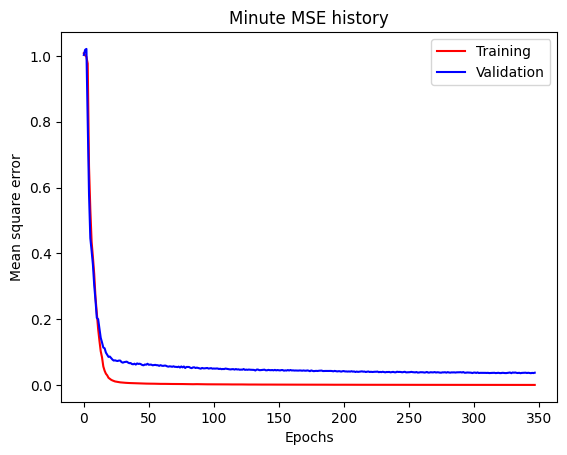

In [137]:

plot_history_loss(hist_df,'loss','val_loss','Loss history')
plot_history_mse(hist_df,'hour_output_mse','val_hour_output_mse','Hour MSE history')
plot_history_mse(hist_df,'minute_output_mse','val_minute_output_mse','Minute MSE history')


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_predictions(predictions, true_values, savedir = None):
    if savedir is None: 
        savedir = f'./plots/predictions_for_model_{iteration}.jpg' 
    else: 
        savedir = savedir + 'predictions_for_model_{iteration}.jpg' 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
    axes = axes.flatten()
    fig.suptitle('Predictive Power of the Model')

    
    cos_h_true, sin_h_true = true_values[0][:,0],true_values[0][:,1]
    cos_m_true, sin_m_true = true_values[1][:,0],true_values[1][:,1]
    hours_true = np.round((np.arctan2(sin_h_true,cos_h_true)%(2*np.pi)) * 12/(2*np.pi))
    minutes_true = np.round((np.arctan2(sin_m_true,cos_m_true)%(2*np.pi)) * 60/(2*np.pi))

    cos_h_pred, sin_h_pred = predictions[0][:,0],predictions[0][:,1]
    cos_m_pred, sin_m_pred = predictions[1][:,0],predictions[1][:,1]
    hours_pred = np.round((np.arctan2(sin_h_pred,cos_h_pred)%(2*np.pi)) * 12/(2*np.pi))
    minutes_pred = np.round((np.arctan2(sin_m_pred,cos_m_pred)%(2*np.pi)) * 60/(2*np.pi))

    print(cos_h_true,sin_h_true)

    hour_mae = mean_absolute_error(hours_true, hours_pred)
    hour_mse = mean_squared_error(hours_true, hours_pred)
    hour_r2 = r2_score(hours_true, hours_pred)

    minute_mae = mean_absolute_error(minutes_true, minutes_pred)
    minute_mse = mean_squared_error(minutes_true, minutes_pred)
    minute_r2 = r2_score(minutes_true, minutes_pred)

    h = axes[0].hist2d(hours_true, hours_pred, bins=12, density=False, cmap='jet')
    fig.colorbar(h[3], ax=axes[0])

    axes[0].plot([0, 12], [0, 12], 'k--',lw=2, label='Perfect Prediction')
    axes[0].set_title(f'Hour Prediction 2D Histogram\nMAE={hour_mae:.2f}, MSE={hour_mse:.2f}, R2={hour_r2:.3f}')
    axes[0].set_xlabel('Actual Hour')
    axes[0].set_ylabel('Predicted Hour')
    axes[0].legend()

    h = axes[1].hist2d(minutes_true, minutes_pred, bins=60, density=False, cmap='jet')
    fig.colorbar(h[3], ax=axes[1])

    axes[1].plot([0, 59], [0, 59], 'k--',lw=3, label='Perfect Prediction')
    axes[1].set_title(f'Minute Prediction 2D Histogram\nMAE={minute_mae:.2f}, MSE={minute_mse:.2f}, R2={minute_r2:.3f}')
    axes[1].set_xlabel('Actual Minute')
    axes[1].set_ylabel('Predicted Minute')
    axes[1].legend()

    plt.savefig(savedir)
    plt.show()
    

[ 6.12323400e-17  6.12323400e-17 -5.00000000e-01 ... -5.00000000e-01
 -8.66025404e-01 -5.00000000e-01] [1.        1.        0.8660254 ... 0.8660254 0.5       0.8660254]


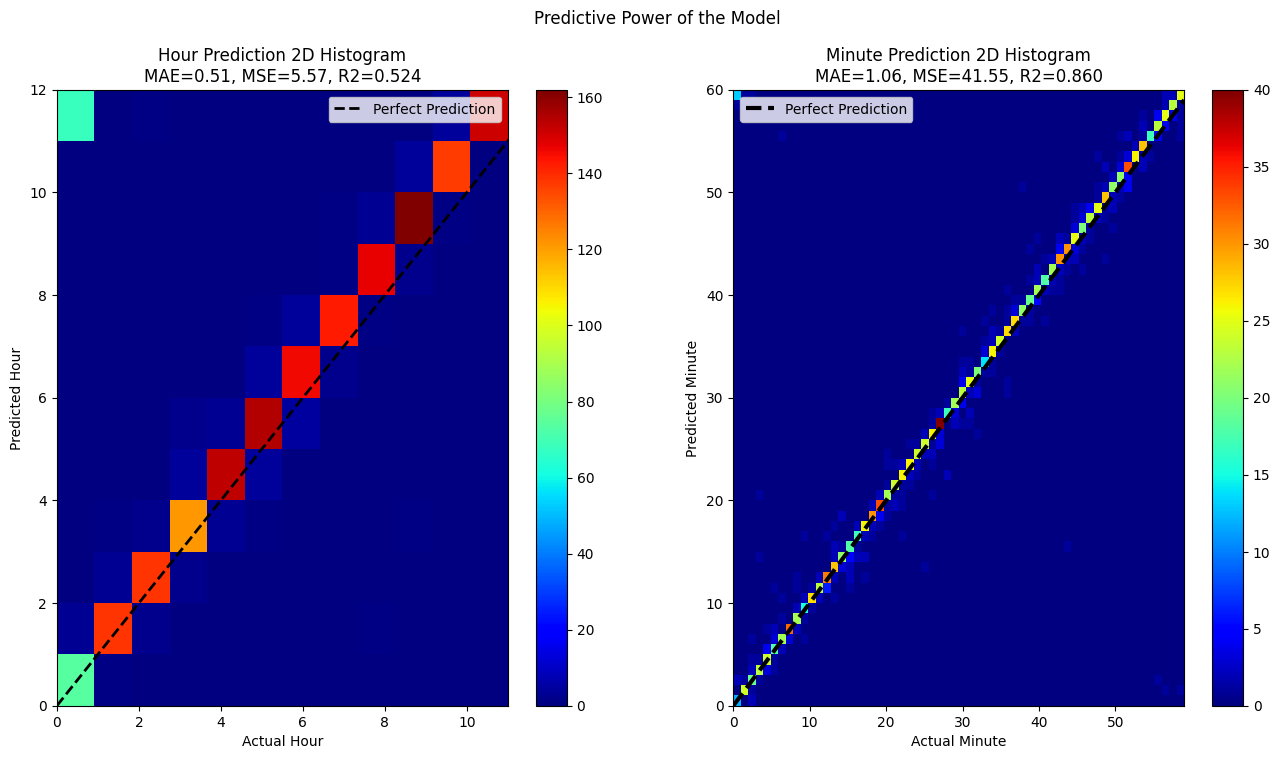

In [51]:
plot_predictions(predictions=predictions,true_values=test_y)

In [47]:
def common_sense_err_reg(y_total_minutes, y_pred_total_minutes):
    y_total_minutes = y_total_minutes
    y_pred_total_minutes = y_pred_total_minutes
    diff = np.abs(y_total_minutes - y_pred_total_minutes)
    circular_diff = np.minimum(diff, 720 - diff)
    mean_error = int(np.mean(circular_diff))
    
    # convert back into hours and minutes
    mean_error_hours = mean_error // 59
    mean_error_minutes = mean_error % 59
    
    return mean_error_hours, mean_error_minutes

In [48]:
cos_h, sin_h = test_y[0][:,0], test_y[0][:,1]
cos_m, sin_m = test_y[1][:,0], test_y[1][:,1]

hour_true = np.floor((np.arctan2(sin_h, cos_h) % (2*np.pi)) * 11 / (2*np.pi)).astype(int)
minute_true = np.floor((np.arctan2(sin_m, cos_m) % (2*np.pi)) * 59 / (2*np.pi)).astype(int)
y_total_minutes = hour_true*60 + minute_true

cos_h, sin_h = predictions[0][:,0], predictions[0][:,1]
cos_m, sin_m = predictions[1][:,0], predictions[1][:,1]

hour_pred = np.floor((np.arctan2(sin_h, cos_h) % (2*np.pi)) * 11 / (2*np.pi)).astype(int)
minute_pred = np.floor((np.arctan2(sin_m, cos_m) % (2*np.pi)) * 59 / (2*np.pi)).astype(int)
y_pred_total_minutes = hour_pred*60 + minute_pred
print(y_pred_total_minutes,y_total_minutes)

mean_error_hours, mean_error_minutes = common_sense_err_reg(y_total_minutes, y_pred_total_minutes)

[159 149 197 ... 192 294 202] [159 149 193 ... 191 294 202]


In [50]:
print(mean_error_hours, mean_error_minutes)

0 9
